In [1]:
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [ ]:
from CTSinogramDataset import CTSinogramDataset

In [4]:
transform = transforms.Compose([transforms.Normalize((0.5,), (0.5,))])

dataset = CTSinogramDataset(
    image_dirs=[
        "../data/images/large_covid_ct_128",
        "../data/images/large_covid_ct_128_augmentation",
    ],
    sinogram_dirs=[
        "../data/sinograms/large_covid_ct_128",
        "../data/sinograms/large_covid_ct_128_augmentation",
    ],
    transform=transform,
)

print(f"Dataset size: {len(dataset)}")

Dataset size: 81175


In [5]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)

In [ ]:
from UNetV1 import UNetV1

In [7]:
model = UNetV1().to(device)
model

UNetV1(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (up2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec2): Sequential(
    (0): Conv2d(256,

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of trainable parameters:", count_parameters(model))

Number of trainable parameters: 1861697


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

In [10]:
epochs = 30

best_weights = None
best_loss = float("inf")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for sino, img in train_dataloader:
        sino = sino.to(device, non_blocking=True)
        img = img.to(device, non_blocking=True)

        output = model(sino)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for sino, img in test_dataloader:
            sino = sino.to(device, non_blocking=True)
            img = img.to(device, non_blocking=True)

            output = model(sino)
            loss = criterion(output, img)
            test_loss += loss.item()

    # Check if this is the best model so far
    if test_loss < best_loss:
        best_loss = test_loss
        best_weights = model.state_dict()

    print(
        f"Epoch {epoch+1}/{epochs} | Loss: {running_loss / len(train_dataloader):.4f} | Test Loss: {test_loss / len(test_dataloader):.4f}"
    )

if best_weights is not None:
    model.load_state_dict(best_weights)
    print("Loaded best model weights with loss:", best_loss)

Epoch 1/30 | Loss: 0.2387 | Test Loss: 0.2238
Epoch 2/30 | Loss: 0.2124 | Test Loss: 0.2131
Epoch 3/30 | Loss: 0.2021 | Test Loss: 0.2132
Epoch 4/30 | Loss: 0.1951 | Test Loss: 0.1916
Epoch 5/30 | Loss: 0.1889 | Test Loss: 0.1901
Epoch 6/30 | Loss: 0.1834 | Test Loss: 0.1847
Epoch 7/30 | Loss: 0.1797 | Test Loss: 0.1808
Epoch 8/30 | Loss: 0.1769 | Test Loss: 0.1792
Epoch 9/30 | Loss: 0.1748 | Test Loss: 0.1793
Epoch 10/30 | Loss: 0.1729 | Test Loss: 0.1774
Epoch 11/30 | Loss: 0.1714 | Test Loss: 0.1744
Epoch 12/30 | Loss: 0.1700 | Test Loss: 0.1754
Epoch 13/30 | Loss: 0.1690 | Test Loss: 0.1705
Epoch 14/30 | Loss: 0.1678 | Test Loss: 0.1692
Epoch 15/30 | Loss: 0.1670 | Test Loss: 0.1756
Epoch 16/30 | Loss: 0.1663 | Test Loss: 0.1685
Epoch 17/30 | Loss: 0.1654 | Test Loss: 0.1694
Epoch 18/30 | Loss: 0.1649 | Test Loss: 0.1707
Epoch 19/30 | Loss: 0.1642 | Test Loss: 0.1679
Epoch 20/30 | Loss: 0.1638 | Test Loss: 0.1694
Epoch 21/30 | Loss: 0.1633 | Test Loss: 0.1668
Epoch 22/30 | Loss: 0.

In [11]:
# Save the model
model_name = "128x128_3007_simple_unet.pth"
model_path = f"../models/{model_name}"

if os.path.exists(model_path):
    print(f"Model {model_name} already exists.")
else:
    print(f"Saving model to {model_path}")
    torch.save(model.state_dict(), model_path)

Saving model to ../models/128x128_3007_simple_unet.pth


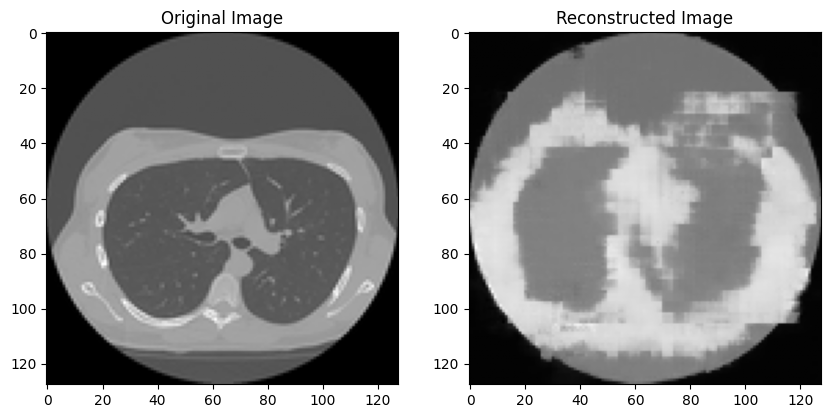

In [15]:
# Example image reconstruction
import matplotlib.pyplot as plt

def show_reconstructed_images(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for sino, img in dataloader:
            sino = sino.to(device, non_blocking=True)
            img = img.to(device, non_blocking=True)

            output = model(sino)

            # Plot the original and reconstructed images
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
            axes[0].imshow(img[1].cpu().numpy().squeeze(), cmap="gray")
            axes[0].set_title("Original Image")
            axes[1].imshow(output[1].cpu().numpy().squeeze(), cmap="gray")
            axes[1].set_title("Reconstructed Image")
            plt.show()
            break

show_reconstructed_images(model, test_dataloader, device)  

In [14]:
# Load model from file
model_path = "../models/128x128_3007_simple_unet.pth"
model = UNetV1().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Test on the test dataset
with torch.no_grad():
    test_loss = 0.0
    for sino, img in test_dataloader:
        sino = sino.to(device, non_blocking=True)
        img = img.to(device, non_blocking=True)

        output = model(sino)
        loss = criterion(output, img)
        test_loss += loss.item()
    print(f"Test Loss: {test_loss / len(test_dataloader):.4f}")

Test Loss: 0.1659


In [ ]:
# Calculate loss on random 128x128 images on the test dataset
import random

test_loss = 0.0
for sino, img in test_dataloader:
    img = img.to(device, non_blocking=True)

    random_img = img[random.randint(0, len(img) - 1)].unsqueeze(0).to(device)

    loss = criterion(random_img, img)
    test_loss += loss.item()
print(f"Test Loss: {test_loss / len(test_dataloader):.4f}")

/home/kamil/.local/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 128, 128])) that is different to the input size (torch.Size([1, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.2444


/home/kamil/.local/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([22, 1, 128, 128])) that is different to the input size (torch.Size([1, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
